# Self-Attention

Self-attention is the core mechanism that allows language models to understand relationships between words in text.

1. Each word in a sentence gets converted to a vector (embedding)
2. The model calculates how much attention each word should pay to every other word
3. This creates an "attention matrix" showing these relationships
4. Words get updated based on their connections to other words

For example, in "The cat sat on the mat", when processing "cat", the model pays attention to "sat" to understand what the cat is doing, creating these meaningful connections automatically.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16 #hyperparameter

#every single token emits two vector, one for key and one for query
key = nn.Linear(C, head_size, bias=False)   # what information do i contain?
query = nn.Linear(C, head_size, bias=False)  # what am i looking for in other tokens?
value = nn.Linear(C, head_size, bias=False) # what information do i contribute?


# Each query vectors dot product with all key vectors to calculate attention scores
# If a query and key are aligned (similar direction), they'll produce a high score

k = key(x)   # (B, T, 16)- keys for all tokens
q = query(x) # (B, T, 16)- queries for all tokens

wei =  q @ k.transpose(-2, -1)# transpose last two dimension # (B, T, 16) @ (B, 16, T) ---> (B, T, T)
# This gives us a BxTxT tensor where each value at position (i,j) 
# represents how much token i should attend to token j
# For each batch, we get a TxT attention matrix (affinity matrix)

tril = torch.tril(torch.ones(T, T))# mask out future positions
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1) # normalize scores to sum to 1

v = value(x)
out = wei @ v

out.shape

torch.Size([4, 8, 16])

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.

- There is no notion of space. Attention simply acts over a set of vectors. This is why **we need to positionally encode tokens**.

- Each example across batch dimension is of course processed completely independently and never "talk" to each other

- In an **"encoder"** attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. Useful for example for sentiment analysis. We are **able to see the "future"**

- **This implementation here is called a "decoder"** attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.


- **"Self-attention"** just means that the keys, queries and values are produced from the same source.
- In **"Cross-attention"** the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)



- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below


$\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$


This is the standard self-attention formula where:
- $Q$ is the query matrix
- $K$ is the key matrix
- $K^T$ is the transpose of the key matrix
- $V$ is the value matrix
- $d_k$ is the dimensionality of the keys (scaling factor)
- The softmax normalizes the attention weights

In [7]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

____________

# SKIP CONNECTIONS

Originally proposed on https://arxiv.org/pdf/1512.03385skip

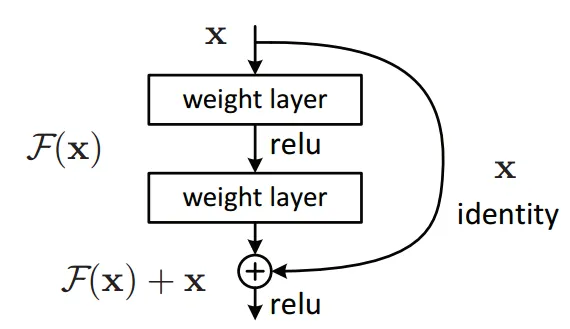

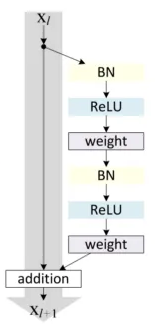

. Specific Benefits in Transformers

- Preserves Original Information: Ensures that some of the original input is always available, preventing complete information loss
- Enables Deeper Networks: Allows training of much deeper networks by making gradient flow easier
- Helps Maintain Contextual Information: Especially crucial in sequence-to-sequence tasks like translation

_____________

# LAYER NORM

### Key Differences from Batch Normalization

   - **Batch Norm**: Normalizes across the batch dimension (columns)
   - **Layer Norm**: Normalizes across the feature dimensions for each individual example (rows)

### Advantages in Transformers

1. **Consistent Normalization**: Works the same way during training and inference
2. **Handles Variable Batch Sizes**: Unlike batch normalization, it doesn't depend on batch statistics
3. **Stabilizes Training**: Helps prevent internal covariate shift


### Practical Insights

- In Transformers, layer normalization is applied:
  1. After multi-head attention
  2. After feed-forward neural networks
- It helps maintain stable activations throughout deep networks
- Allows for more consistent and faster training

In [ ]:
#class BatchNorm1d:
class LayerNorm1d:  
  def __init__(self, dim, eps=1e-5):
    self.eps = eps
    #self.momentum = momentum
    self.training = True # We eliminate difference between training and testing
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    #self.running_mean = torch.zeros(dim)
    #self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(1, keepdim=True) # batch mean#   We dont normalize columns, we normalize rowws!!!
      xvar = x.var(1, keepdim=True) # batch variance#   We dont normalize columns, we normalize rowws!!!
    #else:
    #  xmean = self.running_mean
    #  xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta

    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]


torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

____

# Dropout

Original proposed: https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
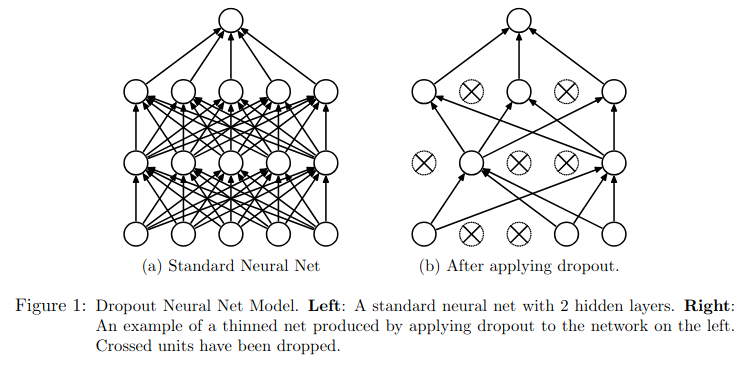

Helps prevent overfitting in neural networks by randomly "dropping out" (setting to zero) a proportion of neurons during training.

### Key Mechanism

- **Random Masking**: During each forward and backward pass, a random subset of neurons is temporarily disabled
- **Dropout Rate**: If dropout is 0.2, 20% of neurons are randomly set to zero in each pass
- **Training vs. Inference**: Applied during training, disabled during inference (with weight scaling)

### How Dropout Works

```python
def dropout(x, dropout_rate):
    # Create a mask of 1s and 0s
    mask = np.random.binomial(1, 1 - dropout_rate, size=x.shape)
    
    # Zero out selected neurons
    return x * mask / (1 - dropout_rate)
```

### Why Dropout is Effective

1. **Prevents Co-adaptation**
   - Stops neurons from becoming too dependent on each other
   - Forces the network to learn more robust, distributed representations

2. **Ensemble-like Behavior**
   - Each training iteration is like training a slightly different network
   - Creates an ensemble effect with a single neural network

3. **Regularization Mechanism**
   - Reduces overfitting by introducing noise during training
   - Improves generalization performance

### Practical Considerations

- **Typical Dropout Rates**:
  - Input layers: 0.2 (20%)
  - Hidden layers: 0.5 (50%)
  - Output layers: Often 0 (no dropout)

- **Placement in Network**
  - Most effective when placed:
    1. Before residual connections
    2. After activation functions
    3. In fully connected layers

### Transformer-Specific Dropout

In transformer architectures, dropout is typically applied:
- After multi-head attention
- After feed-forward networks
- Before residual connections


____________
____________
____________

## Sum up

Quick overview of the work done. The work is inspired by the original proposal in "Attention is all you need"

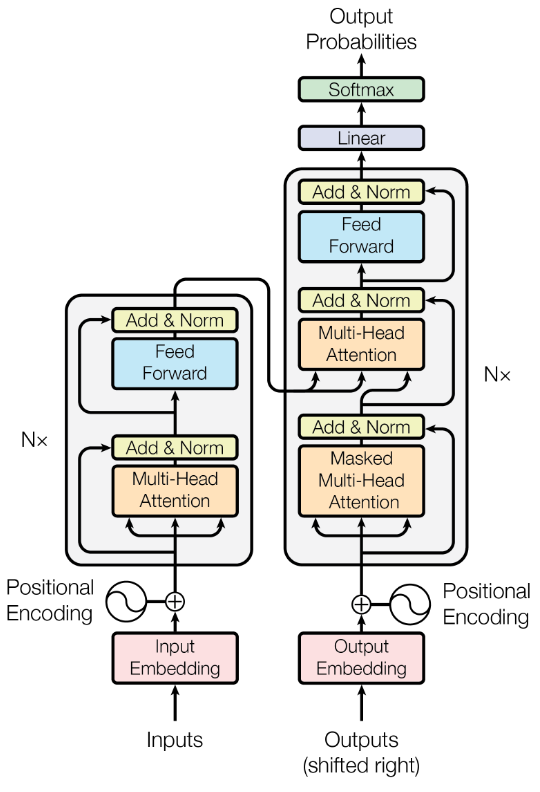

## Key Architectural Modifications

### Decoder-Only Architecture
In contrast to the original, this implementation focuses solely on the decoder block. The original architecture employed two separate components:
- An encoder (input language processing)
- A decoder (output language generation)
- Connected via cross-attention mechanisms

For this project, we're simplifying the model to a generator specifically trained to mimic Monty Python's scripts, thus eliminating the encoder and cross-attention components.

### Layer Normalization Placement
Recent research has shown improved performance by repositioning layer normalization:
- Layer normalization now precedes both:
  1. Multi-head attention layers
  2. Feed-forward neural network layers

This modification is supported by empirical studies demonstrating enhanced model stability and performance when normalization occurs before the transformative layers rather than after.

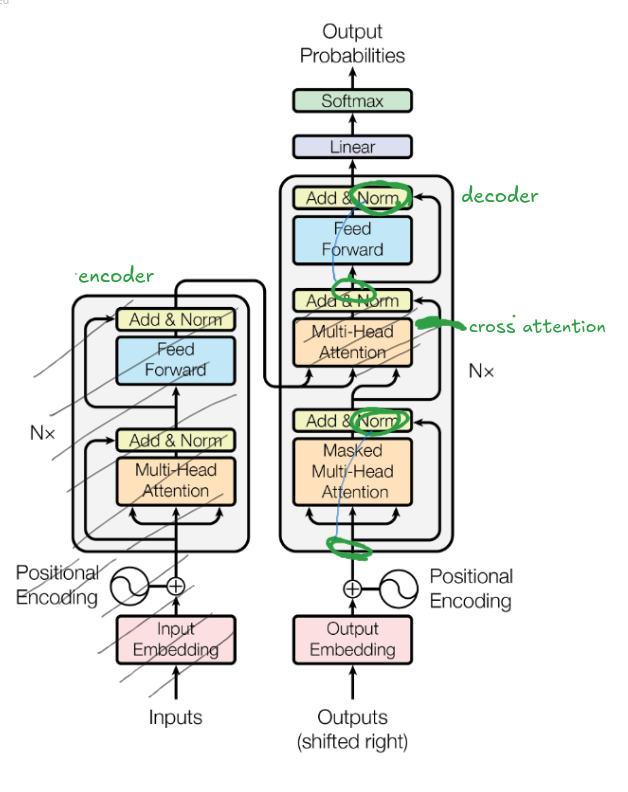

So final arquitecture looks more like this

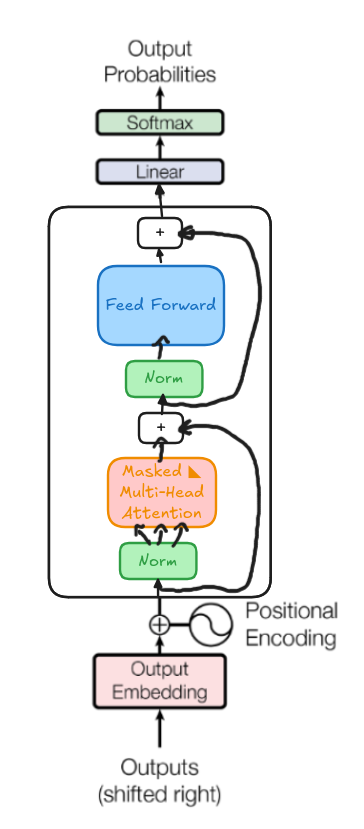
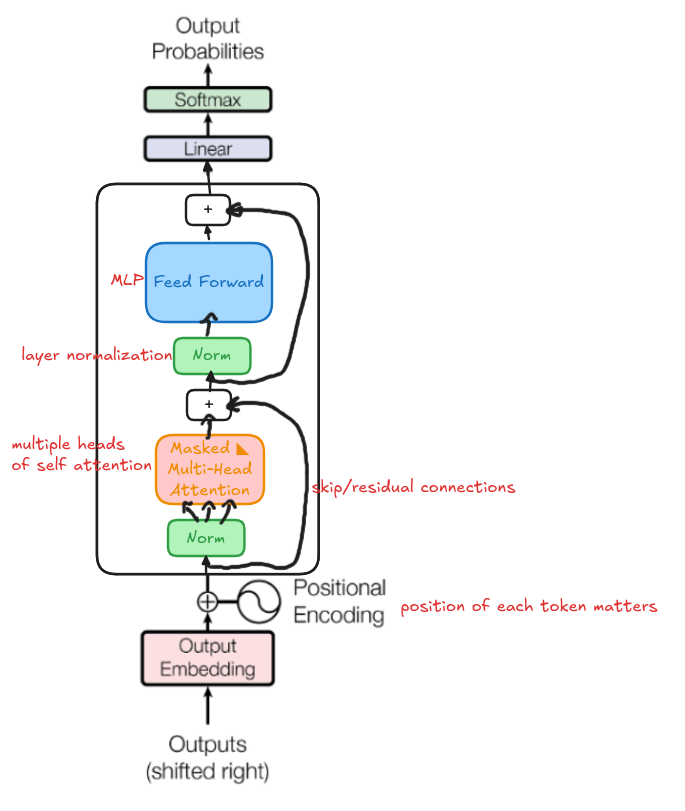